# Introduction
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

**What?** Permutation Importance with Multicollinear or Correlated Features

</font>
</div>

# Import modules
<hr style="border:2px solid black"> </hr>

In [5]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# Load dataset
<hr style="border:2px solid black"> </hr>

In [2]:
data = load_breast_cancer()
X, y = data.data, data.target

# Random forest classifier
<hr style="border:2px solid black"> </hr>

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))

Accuracy on test data: 0.97


# Permutation importance
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

- Tree based feature importance -> plot on the left
- Permutation importance -> plot on the right
- The permutation importance is calculated on the training set to show how much the model relies on each feature during training. 

</font>
</div>

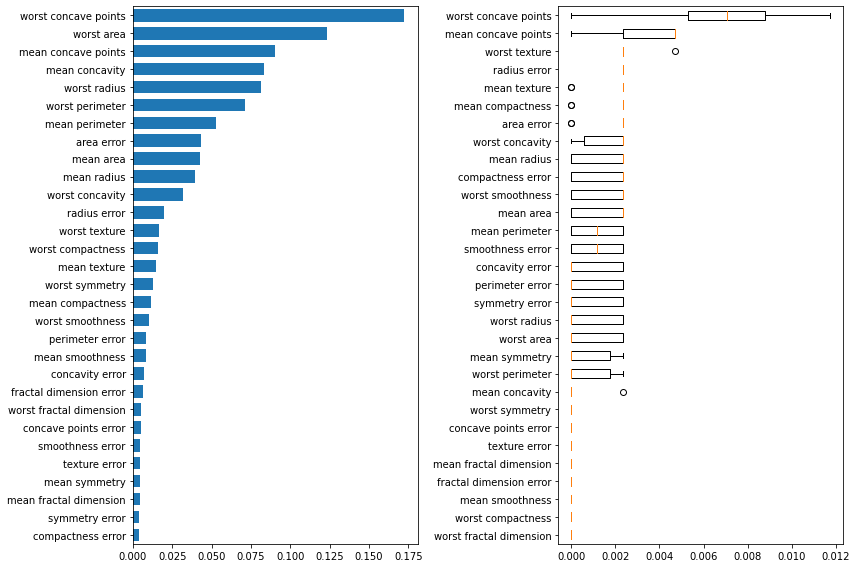

In [6]:
result = permutation_importance(clf, X_train, y_train, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(clf.feature_importances_)))

ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=data.feature_names[perm_sorted_idx])
fig.tight_layout()
plt.show()

<div class="alert alert-info">
<font color=black>

- The permutation importance plot shows that permuting a feature drops the accuracy by **AT MOST** 0.012, which would suggest that none of the features are important. 
- This is in **CONTRADICTION** with the graph on the left obtain using tree feture importance.

</font>
</div>

# Handling Multicollinear Features
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

- When features are collinear, permutating one feature will have little effect on the models performance because it can get the same information from a correlated feature. 
- One way to handle multicollinear features is by performing hierarchical clustering on the Spearman rank-order correlations, picking a threshold, and keeping a single feature from each cluster.

</font>
</div>

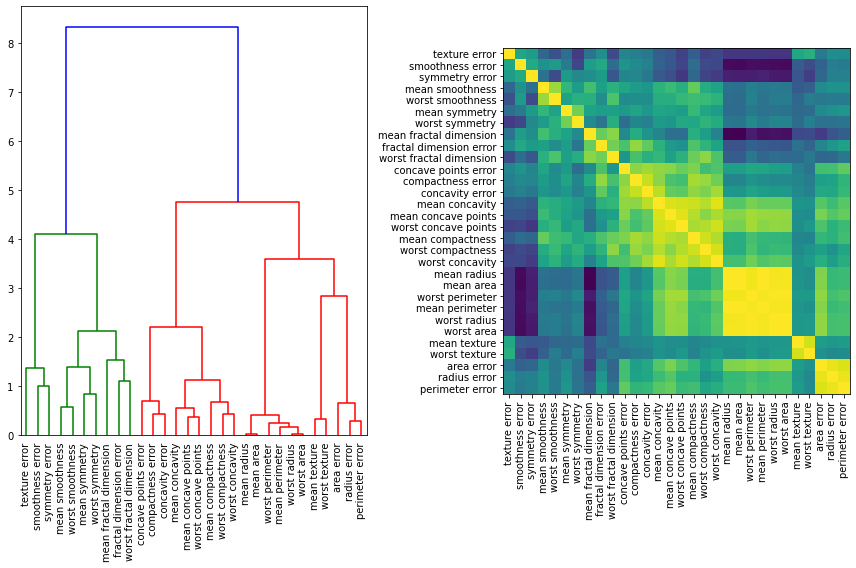

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=data.feature_names.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

<div class="alert alert-info">
<font color=black>

- Next, we manually pick a threshold by visual inspection of the dendrogram to group our features into clusters and choose a feature from each cluster to keep, select those features from our dataset, and train a new random forest. 
- The test accuracy of the new random forest did not change much compared to the random forest trained on the complete dataset. 

</font>
</div>

In [30]:
threshold = 1
cluster_ids = hierarchy.fcluster(corr_linkage, threshold, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

In [31]:
print("All cluster IDs: ", cluster_ids)
print("No of all cluster IDs: ", len(cluster_ids))
print("Selected most important clusters", selected_features)
print("No of selected most important clusters", len(selected_features))

All cluster IDs:  [12 13 12 12  4 11 10 10  5  8 14  3 14 14  1  9  9  9  2  6 12 13 12 12
  4 11 11 10  5  7]
No of all cluster IDs:  30
Selected most important clusters [0, 1, 4, 5, 6, 8, 9, 10, 11, 14, 15, 18, 19, 29]
No of selected most important clusters 14


In [32]:
X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print("Accuracy on test data with features removed: {:.2f}".format(
      clf_sel.score(X_test_sel, y_test)))

Accuracy on test data with features removed: 0.97


# References
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

- https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

</font>
</div>